In [57]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.distributions import constraints
from torch.distributions.distribution import Distribution
from torch.distributions.utils import _sum_rightmost
from torch.nn.parameter import Parameter
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from scipy.special import kn

In [76]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob_lap(self,x):
        z, logp  = self.f(x)
        b = 1
        mu = 0
        log_lap = - math.log(2 * b) - torch.abs(z - mu).div(b)
        #print(z)
        #print(x)
        return   _sum_rightmost(log_lap, 1) + logp 
    
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [77]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [80]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    #noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    x = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((1000,)).numpy() 
    loss = -flow.log_prob_lap(torch.from_numpy(x)).mean()
    #print(-flow.log_prob_lap(torch.from_numpy(x)))
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.904
iter 500: loss = 2.830
iter 1000: loss = 2.826
iter 1500: loss = 2.868
iter 2000: loss = 2.819
iter 2500: loss = 2.835
iter 3000: loss = 2.821
iter 3500: loss = 2.840
iter 4000: loss = 2.862
iter 4500: loss = 2.851
iter 5000: loss = 2.829


Text(0.5, 1.0, '$z = f(X)$')

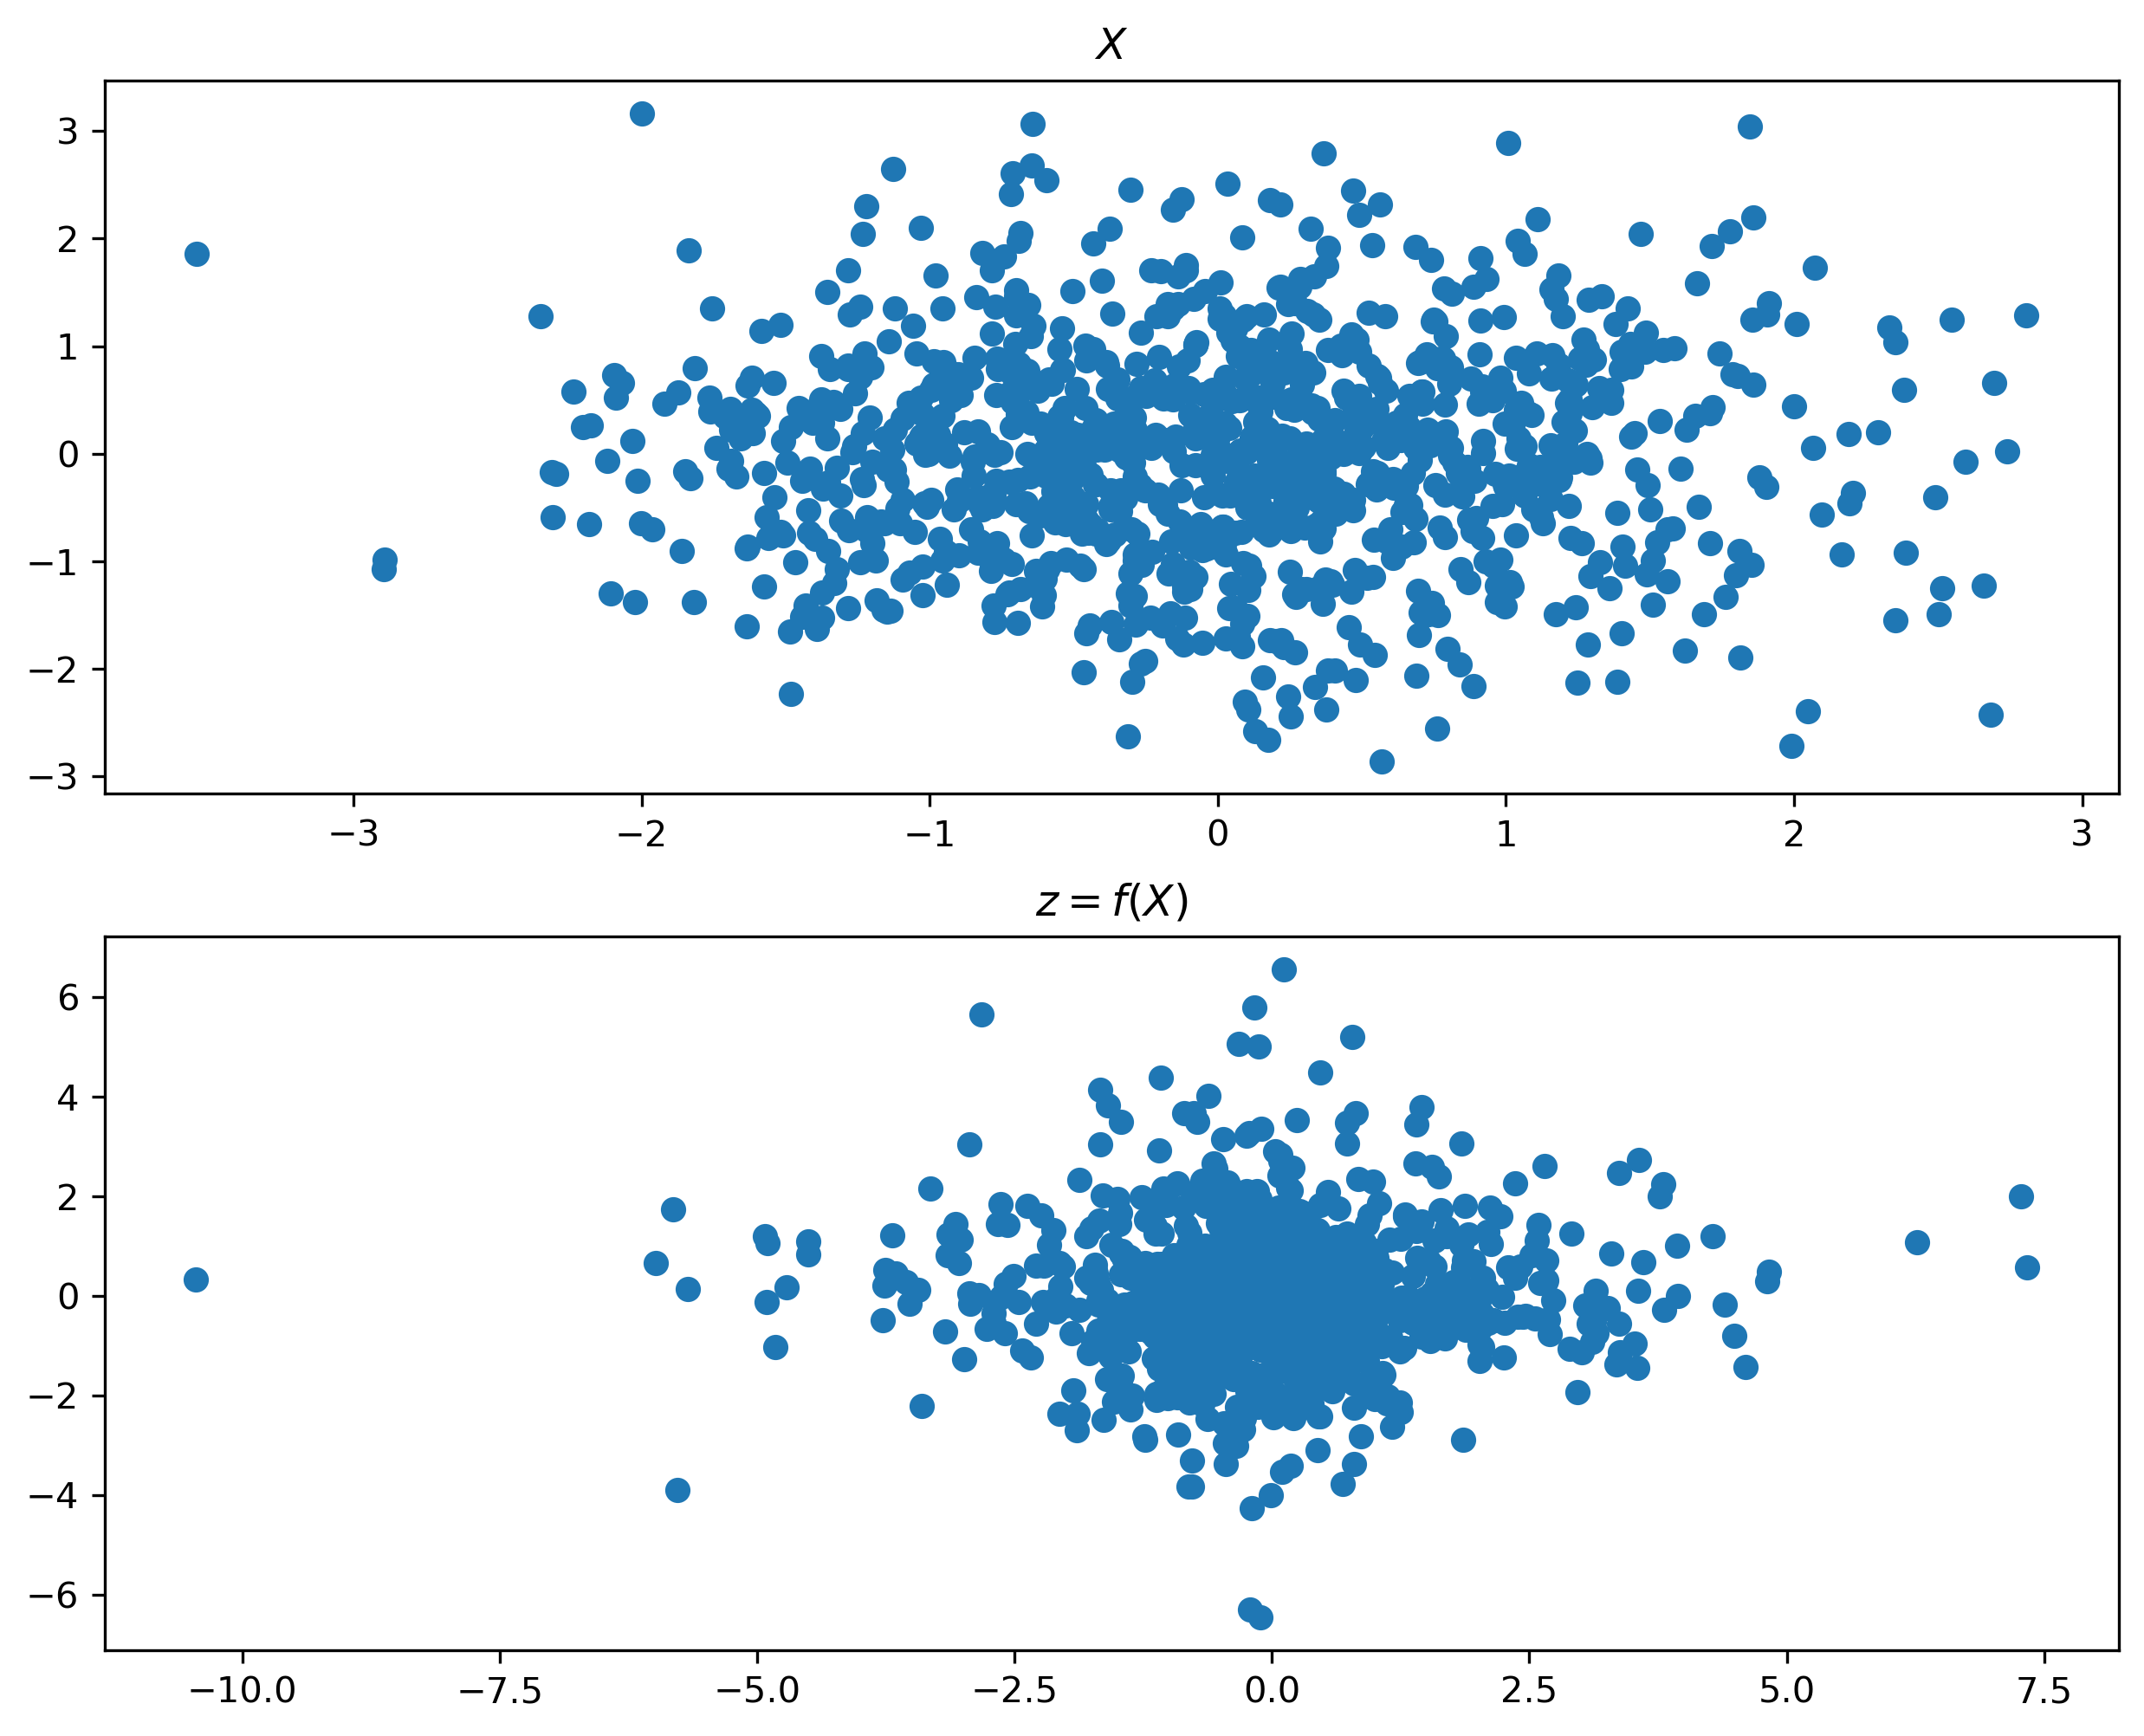

In [89]:
x = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)).sample((1000,)).numpy() 
plt.subplot(211)
plt.scatter(x[:, 0], x[:, 1])
plt.title(r'$X$')

z = flow.f(torch.from_numpy(x))[0].detach().numpy()
plt.subplot(212)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')


([array([  1.,   0.,   4.,  16.,  79., 509., 320.,  58.,  10.,   3.]),
  array([  0.,   0.,   2.,  10.,  92., 493., 336.,  55.,   9.,   3.])],
 array([-10.448932  ,  -8.670911  ,  -6.89289   ,  -5.1148696 ,
         -3.3368487 ,  -1.5588279 ,   0.21919289,   1.9972136 ,
          3.7752345 ,   5.553255  ,   7.331276  ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

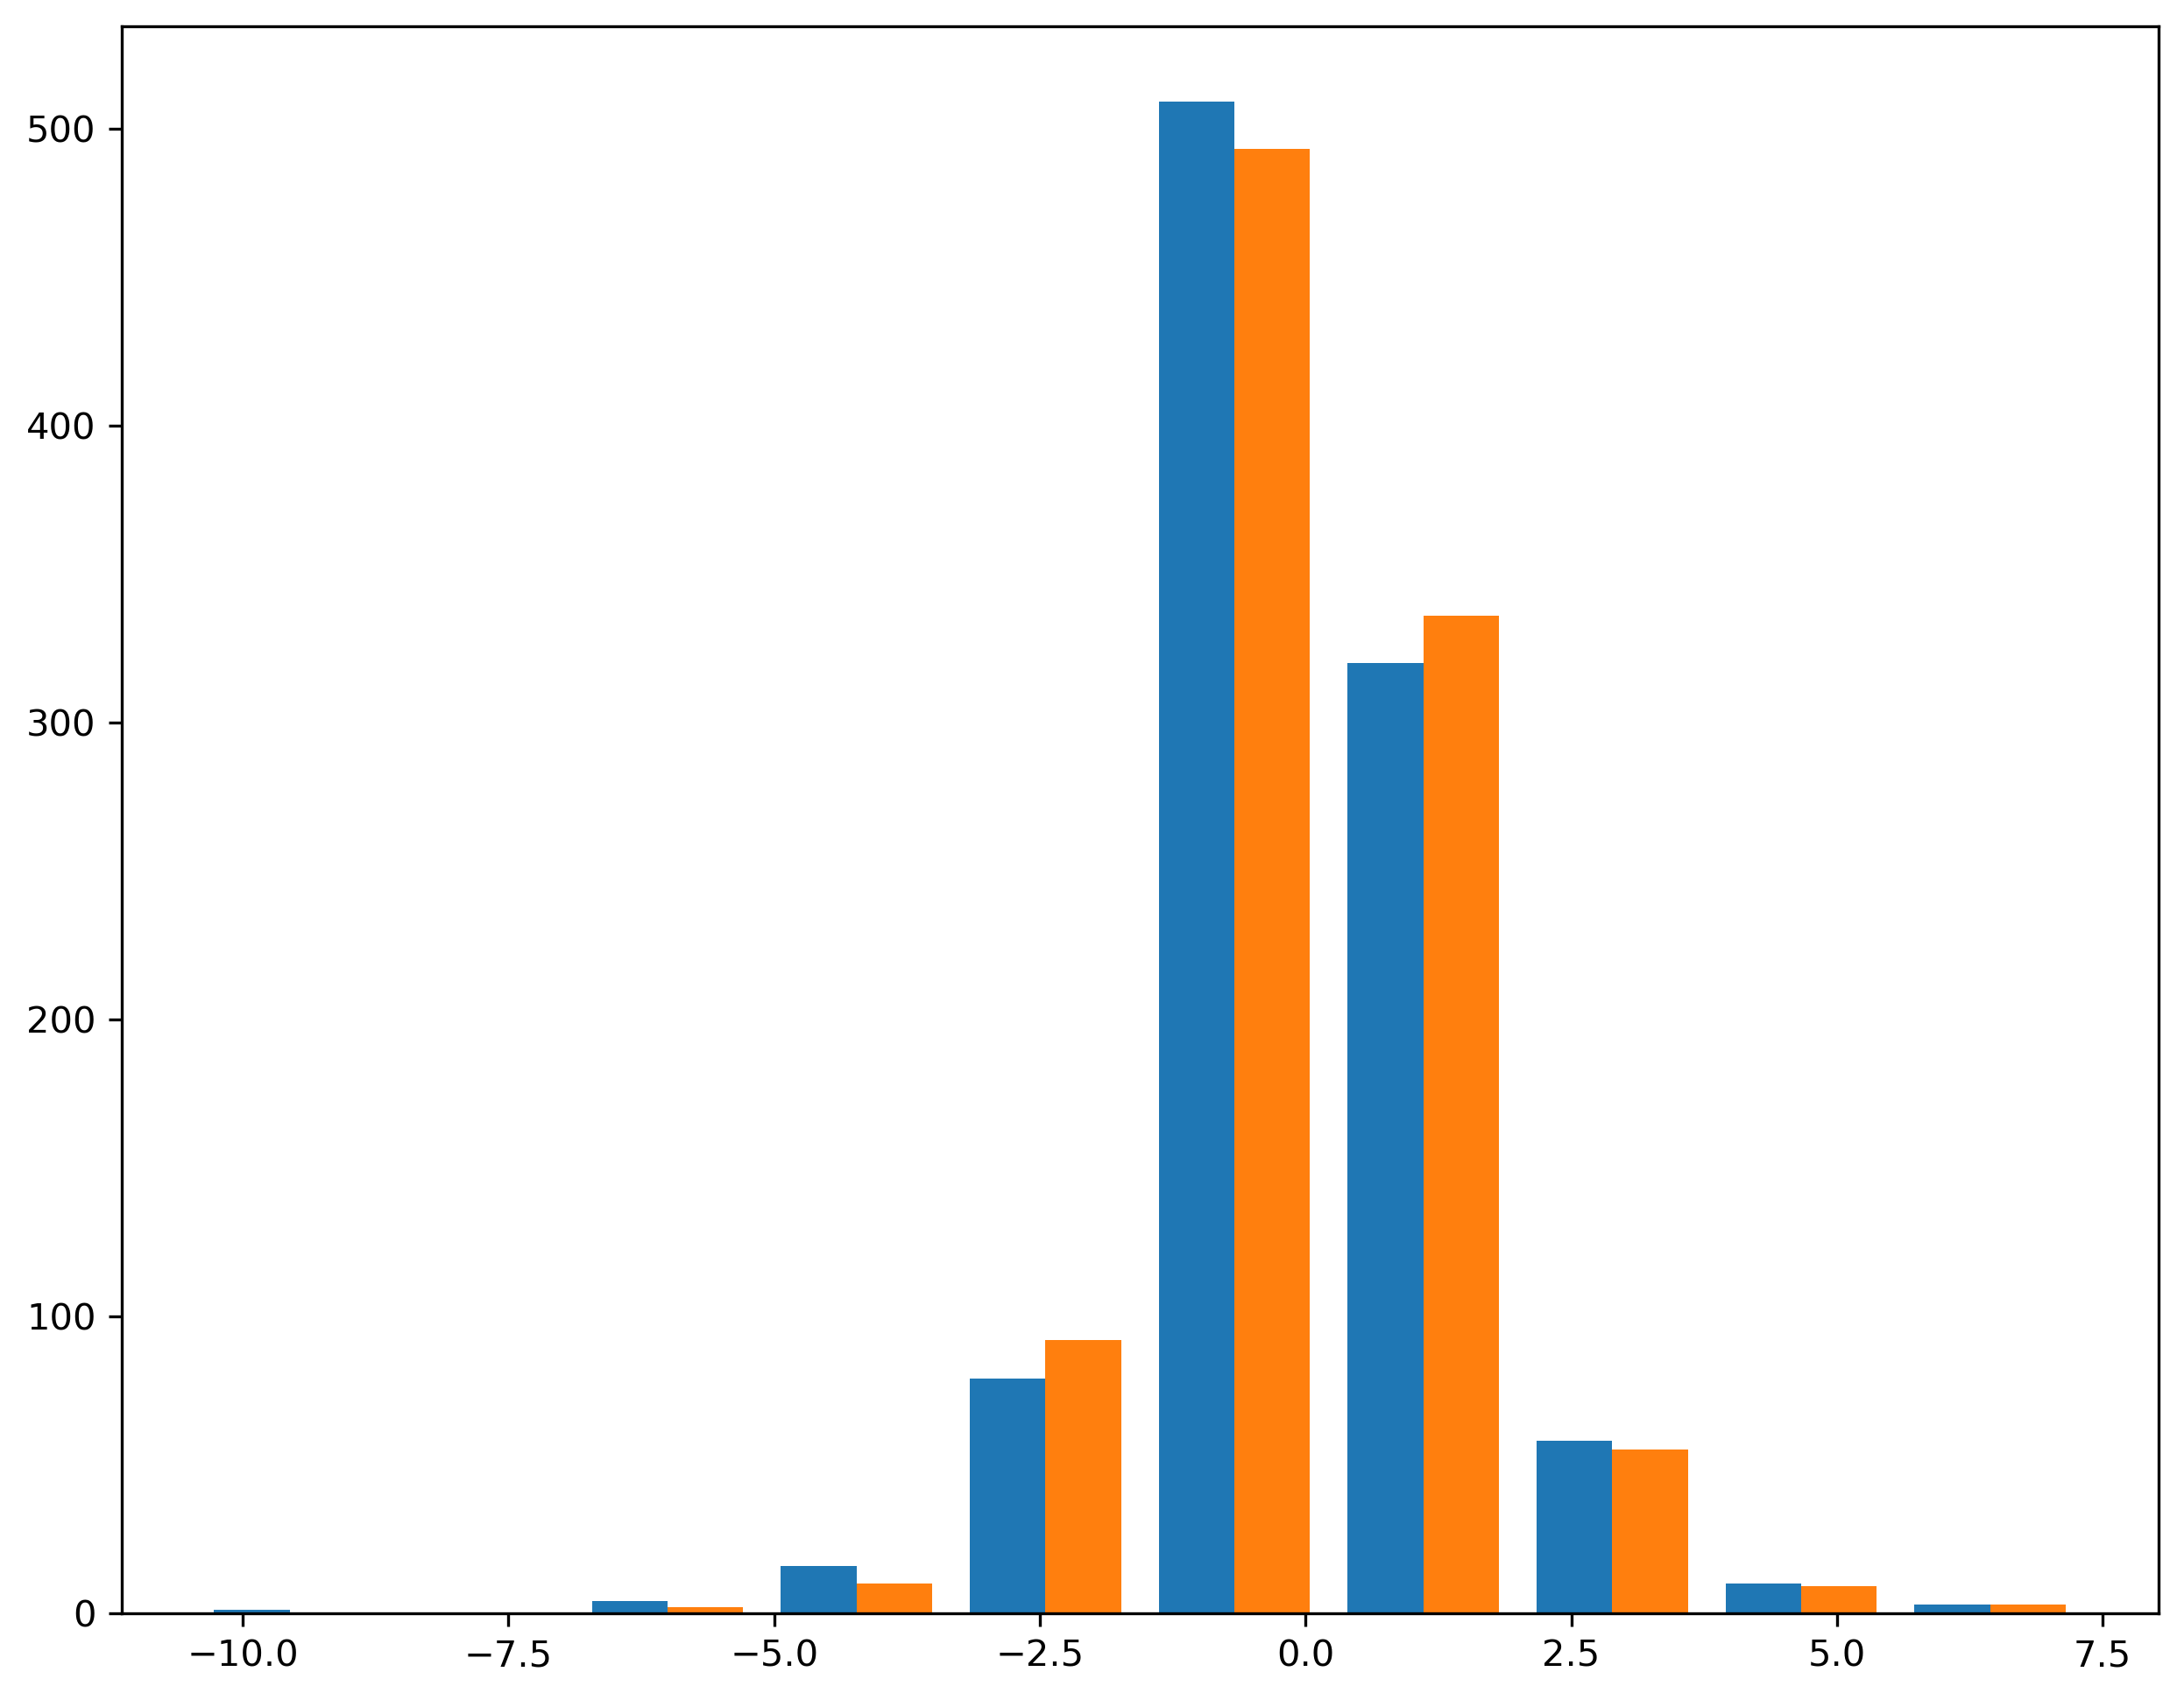

In [90]:
plt.hist(z)